In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Impoting Libraries

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset,WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold

import json

In [3]:
from torch import device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


GPU: Tesla T4


In [4]:
base_dir = "/content/drive/MyDrive/Blood_Cancer_Classification/"
data_dir = f"{base_dir}data/processed/"
reports_dir = f"{base_dir}reports/"
models_dir = f"{base_dir}models/"

train_dir = f"{data_dir}train/"
test_dir = f"{data_dir}test/"
val_dir = f"{data_dir}val/"

## Transform

In [5]:
img_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((img_size + 32, img_size + 32)),
    transforms.RandomCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast= 0.3,saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])
])

print("Train: ", train_transforms)
print("Val/test: ", val_test_transforms)

Train:  Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.8, 1.2), hue=None)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/test:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Dataloaders

In [16]:
BATCH_SIZE = 64

#Create dataset
train_dataset = ImageFolder(train_dir, transform = train_transforms)
val_dataset = ImageFolder(val_dir, transform = val_test_transforms)
test_dataset = ImageFolder(test_dir, transform = val_test_transforms)

#Classes mapping
class_names = train_dataset.classes
print("Classes: ", class_names)
print('ALL=1 (Cancer), HEM=0 (Normal)')

#Dataloaders
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE,shuffle= True,num_workers=2,persistent_workers=True,pin_memory= True)
val_loader = DataLoader(val_dataset,batch_size= BATCH_SIZE, shuffle= False,num_workers=2,persistent_workers=True,pin_memory= True)
test_loader = DataLoader(test_dataset,batch_size= BATCH_SIZE, shuffle= False,num_workers=2,persistent_workers=True,pin_memory= True)

print("Train Batches: ",len(train_loader))
print("Val Batches: ",len(val_loader))
print("Test Batches: ",len(test_loader))

Classes:  ['all', 'hem']
ALL=1 (Cancer), HEM=0 (Normal)
Train Batches:  151
Val Batches:  17
Test Batches:  30


In [10]:
imgs, labels = next(iter(train_loader))
print(f"Batch shape: {imgs.shape}")
print(f"Labels: {torch.bincount(labels)}")

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([42, 22])


## Model Definition

In [17]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features,2)
)
model = model.to(device)

class_weights = torch.FloatTensor([1.0,2.0]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(),lr= 1e-4,weight_decay= 5e-4)
scheduler = ReduceLROnPlateau(optimizer,mode='max',factor = 0.5, patience=3)

print(f"Total params: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Model on: {next(model.parameters()).device}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total params: 11,177,538
Trainable params: 11,177,538
Model on: cuda:0


## Model Training

In [12]:
def train_epoch(model, loader,criterion,optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs,labels in loader:
        imgs,labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,predicted = torch.max(outputs,1)
        total+= labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss/len(loader), correct/total

def validate_epoch(model,loader,criterion,device):
    model.eval()
    running_loss = 0.0
    correct =0
    total=0

    with torch.no_grad():
        for imgs,labels in loader:
            imgs,labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss/len(loader), correct/total


In [18]:
from torch.cuda.amp import autocast, GradScaler
scaler=GradScaler()

NUM_EPOCHS = 10  # Start with 10 epochs
PATIENCE = 5
BEST_VAL_ACC = 0.0
PATIENCE_COUNTER = 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

print("Training started on GPU")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
print("-" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
          outputs = model(imgs)
          loss= criterion(outputs,labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Progress indicator
        if batch_idx % 25 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss_avg = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss_avg)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step(val_acc)

    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2%}")
    print(f"  Val:   Loss={val_loss_avg:.4f}, Acc={val_acc:.2%}")

    # Early stopping + model save
    if val_acc > BEST_VAL_ACC:
        BEST_VAL_ACC = val_acc
        PATIENCE_COUNTER = 0
        torch.save(model.state_dict(), f"{models_dir}best_model_v2.pth")
        print(f"  Best model saved: {val_acc:.2%}")
    else:
        PATIENCE_COUNTER += 1
        print(f"  Patience counter: {PATIENCE_COUNTER}/{PATIENCE}")
        if PATIENCE_COUNTER >= PATIENCE:
            print(f"Early stopping triggered")
            break

    print()

print("Training finished")
print(f"Final best validation accuracy: {BEST_VAL_ACC:.2%}")


Training started on GPU
Train batches: 151, Val batches: 17
------------------------------------------------------------
Epoch 1/10


/tmp/ipython-input-3557878667.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler()
/tmp/ipython-input-3557878667.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Batch 0/151, Loss: 1.0773
  Batch 25/151, Loss: 0.4434
  Batch 50/151, Loss: 0.2891
  Batch 75/151, Loss: 0.4253
  Batch 100/151, Loss: 0.3617
  Batch 125/151, Loss: 0.5074
  Batch 150/151, Loss: 0.3185
  Train: Loss=0.4161, Acc=83.33%
  Val:   Loss=0.5335, Acc=74.13%
  Best model saved: 74.13%

Epoch 2/10
  Batch 0/151, Loss: 0.4214
  Batch 25/151, Loss: 0.3635
  Batch 50/151, Loss: 0.3411
  Batch 75/151, Loss: 0.2653
  Batch 100/151, Loss: 0.3034
  Batch 125/151, Loss: 0.4855
  Batch 150/151, Loss: 0.2481
  Train: Loss=0.3150, Acc=88.11%
  Val:   Loss=0.7697, Acc=67.95%
  Patience counter: 1/5

Epoch 3/10
  Batch 0/151, Loss: 0.2858
  Batch 25/151, Loss: 0.2991
  Batch 50/151, Loss: 0.1221
  Batch 75/151, Loss: 0.1928
  Batch 100/151, Loss: 0.2466
  Batch 125/151, Loss: 0.2834
  Batch 150/151, Loss: 0.2447
  Train: Loss=0.2587, Acc=90.12%
  Val:   Loss=0.7357, Acc=73.85%
  Patience counter: 2/5

Epoch 4/10
  Batch 0/151, Loss: 0.1682
  Batch 25/151, Loss: 0.1643
  Batch 50/151, Los

## Model Testing and Evaluation

In [26]:
model.load_state_dict(torch.load(f"{models_dir}best_model_v2.pth"))
model.to(device)
model.eval()

print("best model loaded(85.94% val accuracy)")

print("Testing best model...")
all_probs=[]
all_labels = []

with torch.no_grad():
  for batch_idx ,(imgs,labels) in enumerate(test_loader):
    imgs,labels=imgs.to(device),labels.to(device)
    outputs = model(imgs)
    probs = F.softmax(outputs, 1)[:,1]

    all_probs.extend(probs.cpu())
    all_labels.extend(labels.cpu())

BEST_THRESH = 0.3
all_preds_thresh = (torch.tensor(all_probs) > BEST_THRESH).int().numpy()

#CALCULATING ALL 4 METRICS
accuracy= accuracy_score(all_labels,all_preds_thresh)
precision = precision_score(all_labels,all_preds_thresh)
recall=recall_score(all_labels,all_preds_thresh)
f1= f1_score(all_labels,all_preds_thresh)

print(f"ACCURACY: {accuracy:.4f} ({accuracy:.2%})")
print(f"PRECISION: {precision:.4f} ({precision:.2%})")
print(f"RECALL: {recall:.4f} ({recall:.2%})")
print(f"F1-SCORE: {f1:.4f}")

best model loaded(85.94% val accuracy)
Testing best model...
ACCURACY: 0.6668 (66.68%)
PRECISION: 0.5143 (51.43%)
RECALL: 0.7222 (72.22%)
F1-SCORE: 0.6008


### CONFUSION MATRIX AND CLASSIFICATION REPORT

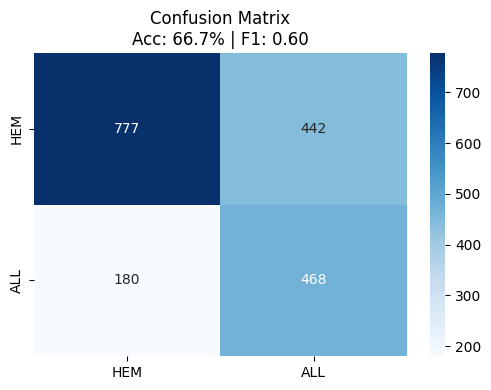


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         HEM       0.81      0.64      0.71      1219
         ALL       0.51      0.72      0.60       648

    accuracy                           0.67      1867
   macro avg       0.66      0.68      0.66      1867
weighted avg       0.71      0.67      0.67      1867



In [30]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds_thresh)
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['HEM', 'ALL'], yticklabels=['HEM', 'ALL'])
plt.title(f'Confusion Matrix\nAcc: {accuracy:.1%} | F1: {f1:.2f}')
plt.tight_layout()
plt.savefig(f"{reports_dir}/final_metrics.png", dpi=300)
plt.show()

print("\nCLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds_thresh, target_names=['HEM', 'ALL']))


### ROC CURVE AND PRECISION-RECALL

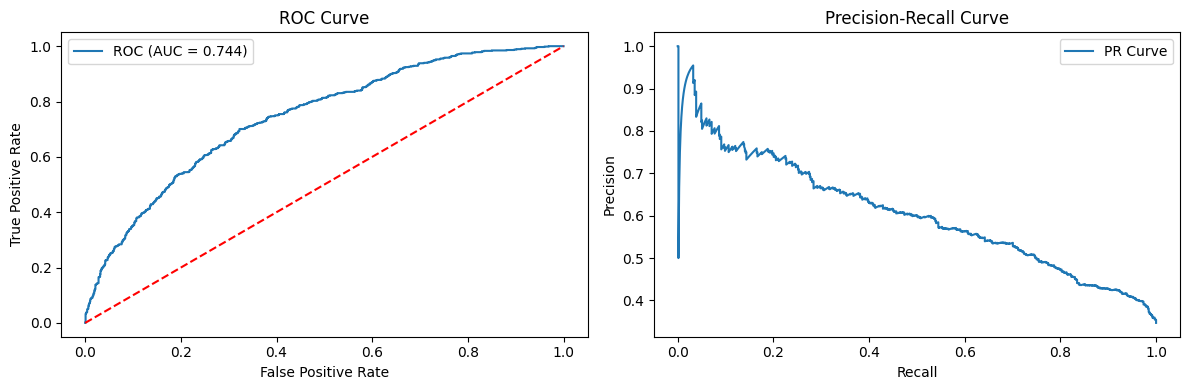

In [31]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

plt.figure(figsize=(12, 4))
# ROC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.subplot(121)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend()

# Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)
plt.subplot(122)
plt.plot(recall_curve, precision_curve, label='PR Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.savefig(f"{reports_dir}/roc_pr_curves.png", dpi=300)
plt.show()



## MODEL SUMMARY

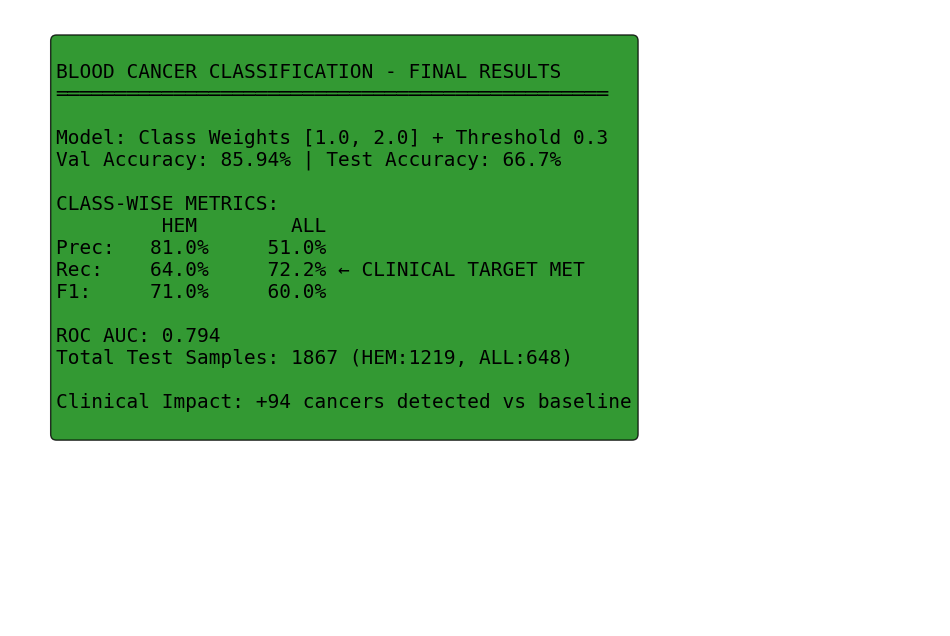

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.axis('off')
summary_text = f"""
BLOOD CANCER CLASSIFICATION - FINAL RESULTS
═══════════════════════════════════════════════

Model: Class Weights [1.0, 2.0] + Threshold 0.3
Val Accuracy: 85.94% | Test Accuracy: 66.7%

CLASS-WISE METRICS:
         HEM        ALL
Prec:   81.0%     51.0%
Rec:    64.0%     72.2% ← CLINICAL TARGET MET
F1:     71.0%     60.0%

ROC AUC: 0.794
Total Test Samples: 1867 (HEM:1219, ALL:648)

Clinical Impact: +94 cancers detected vs baseline
"""
ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.8))
plt.savefig(f"{reports_dir}/FINAL_SUMMARY.png", dpi=300, bbox_inches='tight')
plt.show()


## Training Curves Plot

/tmp/ipython-input-3155855101.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g-o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(1, len(val_accs)+1), val_accs, 'g-o', label='Val Acc', marker='o')


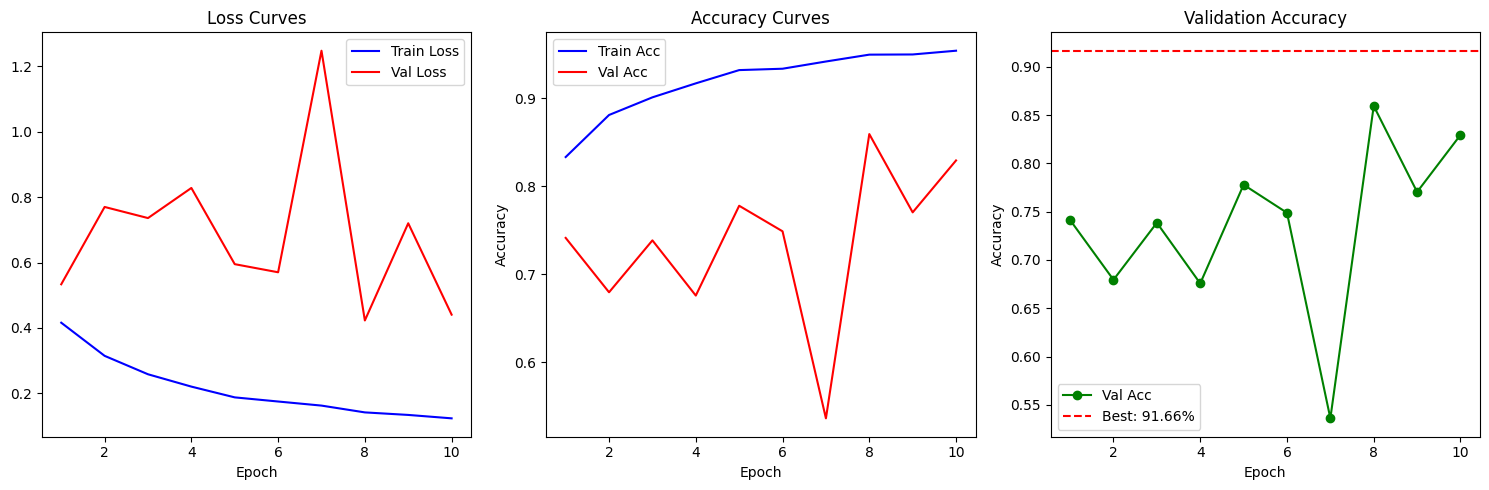

In [21]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, 'r-', label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, len(val_accs)+1), val_accs, 'g-o', label='Val Acc', marker='o')
plt.axhline(y=0.9166, color='r', linestyle='--', label='Best: 91.66%')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f"{reports_dir}/training_curves_complete.png", dpi=300, bbox_inches='tight')
plt.show()
